# 1. PP-OCR系统简介与总览

前两章主要介绍了DBNet文字检测算法以及CRNN文字识别算法。然而对于我们实际场景中的一张图像，想要单独基于文字检测或者识别模型，是无法同时获取文字位置与文字内容的，因此，我们将文字检测算法以及文字识别算法进行串联，构建了PP-OCR文字检测与识别系统。在实际使用过程中，检测出的文字方向可能不是我们期望的方向，最终导致文字识别错误，因此我们在PP-OCR系统中也引入了方向分类器。

本章主要介绍PP-OCR文字检测与识别系统以及该系统中涉及到的优化策略。通过本节课的学习，您可以获得：

* PaddleOCR策略调优技巧
* 文本检测、识别、方向分类器模型的优化技巧和优化方法

PP-OCR系统共经历了2次优化，下面对PP-OCR系统和这2次优化进行简单介绍。

## 1.1 PP-OCR系统与优化策略简介

PP-OCR中，对于一张图像，如果希望提取其中的文字信息，需要完成以下几个步骤：

* 使用文本检测的方法，获取文本区域多边形信息（PP-OCR中文本检测使用的是DBNet，因此获取的是四点信息）。
* 对上述文本多边形区域进行裁剪与透视变换校正，将文本区域转化成矩形框，再使用方向分类器对方向进行校正。
* 基于包含文字区域的矩形框进行文本识别，得到最终识别结果。

上面便完成了对于一张图像的文本检测与识别过程。

PP-OCR的系统框图如下所示。

<p align="center">
 <img src="https://ai-studio-static-online.cdn.bcebos.com/9665bc66a29346d9bf04ef2f664cf488da855a37da2249a3975b809e5e9038c4" align="middle" width = "1200"/>
<p align="center">
<center>PP-OCR系统框图</center>

文本检测基于后处理方案比较简单的DBNet，文字区域校正主要使用几何变换以及方向分类器，文本识别使用了基于融合了卷积特征与序列特征的CRNN模型，使用CTC loss解决预测结果与标签不一致的问题。

PP-OCR从骨干网络、学习率策略、数据增广、模型裁剪量化等方面，共使用了19个策略，对模型进行优化瘦身，最终打造了面向服务器端的PP-OCR server系统以及面向移动端的PP-OCR mobile系统。

## 1.2 PP-OCRv2系统与优化策略简介

相比于PP-OCR， PP-OCRv2 在骨干网络、数据增广、损失函数这三个方面进行进一步优化，解决端侧预测效率较差、背景复杂以及相似字符的误识等问题，同时引入了知识蒸馏训练策略，进一步提升模型精度。具体地：

* 检测模型优化: (1) 采用 CML 协同互学习知识蒸馏策略；(2) CopyPaste 数据增广策略；
* 识别模型优化: (1) PP-LCNet 轻量级骨干网络；(2) U-DML 改进知识蒸馏策略； (3) Enhanced CTC loss 损失函数改进。

从效果上看，主要有三个方面提升：

* 在模型效果上，相对于 PP-OCR mobile 版本提升超7%；
* 在速度上，相对于 PP-OCR server 版本提升超过220%；
* 在模型大小上，11.6M 的总大小，服务器端和移动端都可以轻松部署。

PP-OCRv2 模型与之前 PP-OCR 系列模型的精度、预测耗时、模型大小对比图如下所示。

<p align="center">
 <img src="https://ai-studio-static-online.cdn.bcebos.com/18952983582a4a86853aab4c74e3c429dc0c5ab99f4c48eeb1b28cb0a174aa23" align="middle" width = "800"/>
<p align="center">
<center>PP-OCRv2与PP-OCR的速度、精度、模型大小对比</center>

PP-OCRv2的系统框图如下所示。

<p align="center">
 <img src="https://ai-studio-static-online.cdn.bcebos.com/ccd0d94112bc4adbb42645c71a9a91abeefe4015781646b88da9f223b2d3401f" align="middle" width = "1200"/>
<p align="center">
<center>PP-OCRv2系统框图</center>
  

本章将对上述PP-OCR以及PP-OCRv2系统优化策略进行详细的解读。

# 2. PP-OCR 优化策略

PP-OCR系统包括文本检测器、方向分类器以及文本识别器。本节针对这三个方向的模型优化策略进行详细介绍。

## 2.1 文本检测

PP-OCR中的文本检测基于DBNet (Differentiable Binarization)模型，它基于分割方案，后处理简单。DBNet的具体模型结构如下图。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/33116a2a1f5a4c19b22f366d3f9a360083ff2d8fe7e343fea573eb22a0801143"  width = "1200" />
</div>
<center>DBNet框图</center>

DBNet通过骨干网络(backbone)提取特征，使用DBFPN的结构(neck)对各阶段的特征进行融合，得到融合后的特征。融合后的特征经过卷积等操作(head)进行解码，生成概率图和阈值图，二者融合后计算得到一个近似的二值图。计算损失函数时，对这三个特征图均计算损失函数，这里把二值化的监督也也加入训练过程，从而让模型学习到更准确的边界。

DBNet中使用了6种优化策略用于提升模型精度与速度，包括骨干网络、特征金字塔网络、头部结构、学习率策略、模型裁剪等策略。在验证集上，不同模块的消融实验结论如下所示。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/a78fafbe853e410d9febb5ff412970081609f15a4059493f88c3aa6dc8278d25"  width = "1000" />
</div>
<center>DBNet消融实验</center>


下面进行详细说明。

### 2.1.1 轻量级骨干网络

骨干网络的大小对文本检测器的模型大小有重要影响。因此，在构建超轻量检测模型时，应选择轻量的骨干网络。随着图像分类技术的发展，MobileNetV1、MobileNetV2、MobileNetV3和ShuffleNetV2系列常用作轻量骨干网络。每个系列都有不同的模型大小和性能表现。[PaddeClas](https://github.com/PaddlePaddle/PaddleClas)提供了20多种轻量级骨干网络。他们在ARM上的`精度-速度`曲线如下图所示。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/d3855eac989542d49e5dd69e2f09de284ec02fd2c3314f8b9db7491630e0cd14"  width = "800" />
</div>
<center>PaddleClas中骨干网络的"速度-精度"曲线</center>

在预测时间相同的情况下，MobileNetV3系列可以实现更高的精度。作者在设计的时候为了覆盖尽可能多的场景，使用scale这个参数来调整特征图通道数，标准为1x，如果是0.5x，则表示该网络中部分特征图通道数为1x对应网络的0.5倍。为了进一步平衡准确率和效率，在V3的尺寸选择上，我们采用了MobileNetV3_large 0.5x的结构。

下面打印出DBNet中MobileNetV3各个阶段的特征图尺寸。


In [ ]:
import os
import sys

# 下载代码
os.chdir("/home/aistudio/")
!git clone https://gitee.com/paddlepaddle/PaddleOCR.git
# 切换工作目录
os.chdir("/home/aistudio/PaddleOCR/")
!pip install -U pip
!pip install -r requirements.txt

fatal: destination path 'PaddleOCR' already exists and is not an empty directory.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [ ]:
# 具体代码实现位于：
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/modeling/backbones/det_mobilenet_v3.py
import numpy as np
import paddle

# 设置随机输入
inputs = np.random.rand(1, 3, 640, 640).astype(np.float32)
x = paddle.to_tensor(inputs)

# 导入MobileNetV3库
from ppocr.modeling.backbones.det_mobilenet_v3 import MobileNetV3

# 模型定义
backbone_mv3 = MobileNetV3(scale=0.5, model_name='large')

# 模型forward
bk_out = backbone_mv3(x)

# 模型中间层打印
for i, stage_out in enumerate(bk_out):
    print("the shape of ",i,'stage: ',stage_out.shape)

the shape of  0 stage:  [1, 16, 160, 160]
the shape of  1 stage:  [1, 24, 80, 80]
the shape of  2 stage:  [1, 56, 40, 40]
the shape of  3 stage:  [1, 480, 20, 20]


### 2.1.2 轻量级特征金字塔网络DBFPN结构

文本检测器的特征融合(neck)部分DBFPN与目标检测任务中的FPN结构类似，融合不同尺度的特征图，以提升不同尺度的文本区域检测效果。

为了方便合并不同通道的特征图，这里使用`1×1`的卷积将特征图减少到相同数量的通道。

概率图和阈值图是由卷积融合的特征图生成的，卷积也与inner_channels相关联。因此，inner_channels对模型尺寸有很大的影响。当inner_channels由256减小到96时，模型尺寸由7M减小到4.1M，速度提升48%，但精度只是略有下降。

下面打印DBFPN的结构以及对于骨干网络特征图的融合结果。

In [ ]:
# 具体代码实现位于：
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/modeling/necks/db_fpn.py
from ppocr.modeling.necks.db_fpn import DBFPN

neck_bdfpn = DBFPN(in_channels=[16, 24, 56, 480], out_channels=96)
# 打印 DBFPN结构
print(neck_bdfpn)

# 先对原始的通道数降到96，再降到24，最后4个feature map进行concat
fpn_out = neck_bdfpn(bk_out)

print('the shape of output of DBFPN: ', fpn_out.shape)

DBFPN(
  (in2_conv): Conv2D(16, 96, kernel_size=[1, 1], data_format=NCHW)
  (in3_conv): Conv2D(24, 96, kernel_size=[1, 1], data_format=NCHW)
  (in4_conv): Conv2D(56, 96, kernel_size=[1, 1], data_format=NCHW)
  (in5_conv): Conv2D(480, 96, kernel_size=[1, 1], data_format=NCHW)
  (p5_conv): Conv2D(96, 24, kernel_size=[3, 3], padding=1, data_format=NCHW)
  (p4_conv): Conv2D(96, 24, kernel_size=[3, 3], padding=1, data_format=NCHW)
  (p3_conv): Conv2D(96, 24, kernel_size=[3, 3], padding=1, data_format=NCHW)
  (p2_conv): Conv2D(96, 24, kernel_size=[3, 3], padding=1, data_format=NCHW)
)
the shape of output of DBFPN:  [1, 96, 160, 160]


### 2.1.3 骨干网络中SE模块分析

SE是`squeeze-and-excitation`的缩写(Hu, Shen, and Sun 2018)。如图所示

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/9685731c2d65435b9fa6ede7e2dec5da77262d1f15704280a3207207e3946c7f"  width = "1200" />
</div>
<center>SE模块示意图</center>

SE块显式地建模通道之间的相互依赖关系，并自适应地重新校准通道特征响应。在网络中使用SE块可以明显提高视觉任务的准确性，因此MobileNetV3的搜索空间包含了SE模块，最终MobileNetV3中也包含很多个SE模块。然而，当输入分辨率较大时，例如`640×640`，使用SE模块较难估计通道的特征响应，精度提高有限，但SE模块的时间成本非常高。在DBNet中，**我们将SE模块从骨干网络中移除**，模型大小从`4.1M`降到`2.6M`，但精度没有影响。

PaddleOCR中可以通过设置`disable_se=True`来移除骨干网络中的SE模块，使用方法如下所示。

In [ ]:
# 具体代码实现位于：
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/modeling/backbones/det_mobilenet_v3.py

x = paddle.rand([1, 3, 640, 640])

from ppocr.modeling.backbones.det_mobilenet_v3 import MobileNetV3

# 定义模型
backbone_mv3 = MobileNetV3(scale=0.5, model_name='large', disable_se=True)

# 模型forward
bk_out = backbone_mv3(x)
# 输出
for i, stage_out in enumerate(bk_out):
    print("the shape of ",i,'stage: ',stage_out.shape)

the shape of  0 stage:  [1, 16, 160, 160]
the shape of  1 stage:  [1, 24, 80, 80]
the shape of  2 stage:  [1, 56, 40, 40]
the shape of  3 stage:  [1, 480, 20, 20]


### 2.1.4 学习率策略优化

* Cosine 学习率下降策略

梯度下降算法需要我们设置一个值，用来控制权重更新幅度，我们将其称之为学习率。它是控制模型学习速度的超参数。学习率越小，loss的变化越慢。虽然使用较低的学习速率可以确保不会错过任何局部极小值，但这也意味着模型收敛速度较慢。

因此，在训练前期，权重处于随机初始化状态，我们可以设置一个相对较大的学习速率以加快收敛速度。在训练后期，权重接近最优值，使用相对较小的学习率可以防止模型在收敛的过程中发生震荡。

Cosine学习率策略也就应运而生，Cosine学习率策略指的是学习率在训练的过程中，按照余弦的曲线变化。在整个训练过程中，Cosine学习率衰减策略使得在网络在训练初期保持了较大的学习速率，在后期学习率会逐渐衰减至0，其收敛速度相对较慢，但最终收敛精度较好。下图比较了两种不同的学习率衰减策略`piecewise decay`和`cosine decay`。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/e9f48fda04c14d5787c0cea52f0e75d85b8f50aee70a4ee3adfc17da5158a72a"  width = "800" />
</div>
<center>Cosine与Piecewise学习率下降策略</center>

* 学习率预热策略

模型刚开始训练时，模型权重是随机初始化的，此时若选择一个较大的学习率,可能造成模型训练不稳定的问题，因此**学习率预热**的概念被提出，用于解决模型训练初期不收敛的问题。

学习率预热指的是将学习率从一个很小的值开始，逐步增加到初始较大的学习率。它可以保证模型在训练初期的稳定性。使用学习率预热策略有助于提高图像分类任务的准确性。在DBNet中，实验表明该策略也是有效的。学习率预热策略与Cosine学习率结合时，学习率的变化趋势如下代码演示。


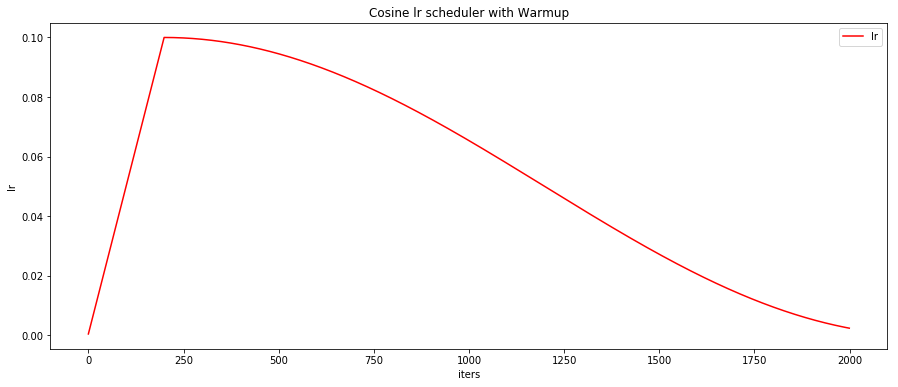

In [ ]:
# 具体代码实现位于
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/optimizer/__init__.py
# 导入学习率优化器构建的函数
from ppocr.optimizer import build_lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# 咱们也可以看看warmup_epoch为2时的效果
lr_config = {'name': 'Cosine', 'learning_rate': 0.1, 'warmup_epoch': 2}
epochs = 20 # config['Global']['epoch_num']
iters_epoch = 100  # len(train_dataloader)
lr_scheduler=build_lr_scheduler(lr_config, epochs, iters_epoch)

iters = 0
lr = []
for epoch in range(epochs):
    for _ in range(iters_epoch):
        lr_scheduler.step() # 对应 https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/tools/program.py#L262
        iters += 1
        lr.append(lr_scheduler.get_lr())

x = np.arange(iters,dtype=np.int64)
y = np.array(lr,dtype=np.float64)

plt.figure(figsize=(15, 6))
plt.plot(x,y,color='red',label='lr')

plt.title(u'Cosine lr scheduler with Warmup')
plt.xlabel(u'iters')
plt.ylabel(u'lr')

plt.legend()

plt.show()

### 2.1.5 模型裁剪策略-FPGM

深度学习模型中一般有比较多的参数冗余，我们可以使用一些方法，去除模型中比较冗余的地方，从而提升模型推理效率。

模型裁剪指的是通过去除网络中冗余的通道（channel）、滤波器（filter）、神经元（neuron）等，来得到一个更轻量的网络，同时尽可能保证模型精度。

相比于裁剪通道或者特征图的方法，裁剪滤波器的方法可以得到更加规则的模型，因此减少内存消耗，加速模型推理过程。

之前的裁剪滤波器的方法大多基于范数进行裁剪，即，认为范数较小的滤波器重要程度较小，但是这种方法要求存在的滤波器的最小范数应该趋近于0，否则我们难以去除。

针对上面的问题，基于**几何中心点的裁剪算法**(Filter Pruning via Geometric Median, FPGM)被提出。FPGM将卷积层中的每个滤波器都作为欧几里德空间中的一个点，它引入了几何中位数这样一个概念，即**与所有采样点距离之和最小的点**。如果一个滤波器的接近这个几何中位数，那我们可以认为这个滤波器的信息和其他滤波器重合，可以去掉。

FPGM与基于范数的裁剪算法的对比如下图所示。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/13f84e7c4ce84d39b3e06adec20efed0e600dbfff1dc4db9b6498ba33d73925d"  width = "800" />
</div>
<center>FPGM裁剪示意图</center>


在PP-OCR中，我们使用FPGM对检测模型进行剪枝，最终DBNet的模型精度只有轻微下降，但是模型大小减小**46%**，预测速度加速**19%**。

关于FPGM模型裁剪实现的更多细节可以参考[PaddleSlim](https://github.com/PaddlePaddle/PaddleSlim/blob/release/2.0.0/docs/zh_cn/api_cn/dygraph/pruners/fpgm_filter_pruner.rst#fpgmfilterpruner)。


**注意：**

1. 模型裁剪需要重新训练模型，可以参考[PaddleOCR剪枝教程](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.3/deploy/slim/prune/README.md)。
2. 裁剪代码是根据DBNet进行适配，如果您需要对自己的模型进行剪枝，需要重新分析模型结构、参数的敏感度，我们通常情况下只建议裁剪相对敏感度低的参数，而跳过敏感度高的参数。
3. 每个卷积层的剪枝率对于裁剪后模型的性能也很重要，用完全相同的裁剪率去进行模型裁剪通常会导致显着的性能下降。
4. 模型裁剪不是一蹴而就的，需要进行反复的实验，才能得到符合要求的模型。

### 2.1.6 文本检测配置说明

下面给出DBNet的训练配置简要说明，完整的配置文件可以参考：[ch_det_mv3_db_v2.0.yml](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/configs/det/ch_ppocr_v2.0/ch_det_mv3_db_v2.0.yml)。

```yaml
Architecture:                       # 模型结构定义
  model_type: det
  algorithm: DB
  Transform:
  Backbone:
    name: MobileNetV3               # 配置骨干网络
    scale: 0.5
    model_name: large
    disable_se: True                # 去除SE模块
  Neck:
    name: DBFPN                     # 配置DBFPN
    out_channels: 96                # 配置 inner_channels
  Head:
    name: DBHead
    k: 50

Optimizer:
  name: Adam
  beta1: 0.9
  beta2: 0.999
  lr:
    name: Cosine                   # 配置cosine学习率下降策略
    learning_rate: 0.001           # 初始学习率
    warmup_epoch: 2                # 配置学习率预热策略
  regularizer:
    name: 'L2'                     # 配置L2正则
    factor: 0                      # 正则项的权重
```

### 2.1.7 PP-OCR 检测优化总结

上面给大家介绍了PP-OCR中文字检测算法的优化策略，这里再给大家回顾一下不同优化策略对应的消融实验与结论。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/a78fafbe853e410d9febb5ff412970081609f15a4059493f88c3aa6dc8278d25"  width = "1000" />
</div>
<center>DBNet消融实验</center>

通过轻量级骨干网络、轻量级neck结构、SE模块的分析和去除、学习率调整及优化、模型裁剪等策略，DBNet的模型大小从**7M**减少至**1.5M**。通过学习率策略优化等训练策略优化，DBNet的模型精度提升超过**1%**。

PP-OCR中，超轻量DBNet检测效果如下所示：

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/593321ac0ec34cd39ca4c3755de0bc6ee15b19d24ccc4fe7b37c194b7e825187"  width = "800" />
</div>

下面展示快速使用文字检测模型的预测效果。具体的预测推理代码，我们在第五章会进行详细说明。

mkdir: cannot create directory ‘inference’: File exists
--2021-12-24 21:07:17--  https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_det_infer.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 182.61.200.229, 182.61.200.195, 2409:8c04:1001:1002:0:ff:b001:368a
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|182.61.200.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190272 (3.0M) [application/x-tar]
Saving to: ‘ch_PP-OCRv2_det_infer.tar’

ch_PP-OCRv2_det_inf 100%[===================>]   3.04M  4.13MB/s    in 0.7s    

2021-12-24 21:07:18 (4.13 MB/s) - ‘ch_PP-OCRv2_det_infer.tar’ saved [3190272/3190272]

[2021/12/24 21:07:22] root INFO: 00111002.jpg	[[[78, 641], [408, 638], [408, 659], [78, 662]], [[76, 614], [214, 614], [214, 635], [76, 635]], [[103, 554], [150, 554], [150, 576], [103, 576]], [[74, 531], [349, 531], [349, 551], [74, 551]], [[75, 503], [310, 499], [311, 523], [75, 527]], [[162, 462], [320, 462], [320

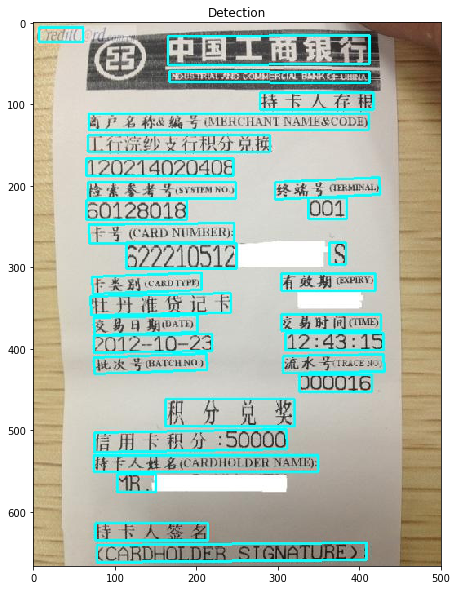

In [ ]:
!mkdir inference
!cd inference && wget https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_det_infer.tar -O ch_PP-OCRv2_det_infer.tar && tar -xf ch_PP-OCRv2_det_infer.tar
!python tools/infer/predict_det.py --image_dir="./doc/imgs/00111002.jpg" --det_model_dir="./inference/ch_PP-OCRv2_det_infer" --use_gpu=False
from PIL import Image
img_det = Image.open('./inference_results/det_res_00111002.jpg')

plt.figure(figsize=(14, 10)) # 图像窗口大小
plt.imshow(img_det)
plt.axis('on')
plt.title('Detection')
plt.show()

## 2.2 方向分类器

方向分类器的任务是用于分类出文本检测出的文本实例的方向，将文本旋转到0度之后，再送入后续的文本识别器中。PP-OCR中，我们考虑了**0**度和**180**度2个方向。下面详细介绍针对方向分类器的速度、精度优化策略。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/65b6e5d75f22403aba50665a1ab6dbba51cdb47eff0845d1909e5e54fd48e336"  width = "1200" />
</div>
<center>方向分类器消融实验</center>

### 2.2.1 轻量级骨干网络

与文本检测器相同，我们仍然采用MobileNetV3作为方向分类器的骨干网络。因为方向分类的任务相对简单，我们使用MobileNetV3 small 0.35x来平衡模型精度与预测效率。实验表明，即使当使用更大的骨干时，精度不会有进一步的提升。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/9177cfe7d294423e9f7e330d3c11ed4cafb46948305346a69a0edaee2b128890"  width = "1000" />
</div>
<center>不同骨干网络下的方向分类器精度对比</center>

### 2.2.2 数据增强

数据增强指的是对图像变换，送入网络进行训练，它可以提升网络的泛化性能。常用的数据增强包括旋转、透视失真变换、运动模糊变换和高斯噪声变换等，PP-OCR中，我们统称这些数据增强方法为BDA(Base Data Augmentation)。结果表明，BDA可以明显提升方向分类器的精度。

下面展示一些BDA数据增广方法的效果

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/b78ce4772e684804bb22f20bf806dab2128793fd30e04e74b660f24dc636d68a"  width = "1000" />
</div>
<center>BDA数据增广效果</center>


除了BDA外，我们还加入了一些更高阶的数据增强操作来提高分类的效果，例如 AutoAugment (Cubuk et al. 2019), RandAugment (Cubuk et al. 2020), CutOut (DeVries and Taylor 2017), RandErasing (Zhong et al. 2020), HideAndSeek (Singh and Lee 2017), GridMask (Chen 2020), Mixup (Zhang et al. 2017) 和 Cutmix (Yun et al. 2019)。

这些数据增广大体分为3个类别：

（1）图像变换类：AutoAugment、RandAugment

（2）图像裁剪类：CutOut、RandErasing、HideAndSeek、GridMask

（3）图像混叠类：Mixup、Cutmix

下面给出不同高阶数据增广的可视化对比结果。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/3d71ffaa2c3b4b7ebf7a39256d8607f205ce9a9e22eb4908bce75066a4a0f0f2"  width = "1200" />
</div>
<center>高阶数据增广可视化效果</center>


但是实验表明，除了RandAugment 和 RandErasing 外，大多数方法都不适用于方向分类器。下图也给出了在不同数据增强策略下，模型精度的变化。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/0f85faaa6dd6429882e33827384a2d4fac9f4d8c3f804a249917779c97790e7c"  width = "1000" />
</div>

最终，我们在训练时结合BDA和RandAugment，作为方向分类器的数据增强策略。

* RandAugment代码演示

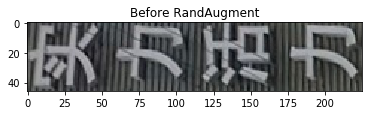

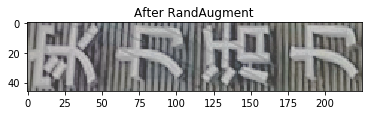

In [ ]:
# 参考代码：
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/data/imaug/__init__.py
import random
from PIL import Image
from ppocr.data.imaug import DecodeImage, RandAugment, transform

np.random.seed(1)
random.seed(1)

img = Image.open('./doc/imgs_words/ch/word_4.jpg')

# 绘制原图
plt.figure("Image1") # 图像窗口名称
plt.imshow(img)
plt.axis('on') # 关掉坐标轴为 off
plt.title('Before RandAugment') # 图像题目
plt.show()


data = {'image':None}
with open('./doc/imgs_words/ch/word_4.jpg', 'rb') as f:
    img = f.read()
    data['image'] = img

# 定义变换算子
ops_list = [DecodeImage(), RandAugment()]

# 数据变换
data = transform(data,ops_list)

img_auged = data['image']

# 显示
img_auged = Image.fromarray(img_auged, 'RGB')
plt.figure("Image") # 图像窗口名称
plt.imshow(img_auged)
plt.axis('on') # 关掉坐标轴为 off
plt.title('After RandAugment') # 图像标题
plt.show()

下面展示快速使用方向分类器模型的预测效果。具体的预测推理代码，我们在第五章会进行详细说明。

--2021-12-24 21:19:04--  https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 182.61.200.195, 182.61.200.229, 2409:8c04:1001:1002:0:ff:b001:368a
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|182.61.200.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1454080 (1.4M) [application/x-tar]
Saving to: ‘ch_ppocr_mobile_v2.0_cls_infer.tar’

ch_ppocr_mobile_v2. 100%[===================>]   1.39M  --.-KB/s    in 0.1s    

2021-12-24 21:19:04 (14.3 MB/s) - ‘ch_ppocr_mobile_v2.0_cls_infer.tar’ saved [1454080/1454080]

[2021/12/24 21:19:06] root INFO: Predicts of ./doc/imgs_words/ch/word_1.jpg:['0', 0.9998784]


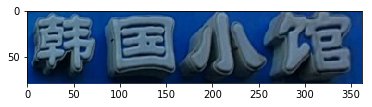

[2021/12/24 21:19:09] root INFO: Predicts of ./test.png:['180', 0.9999759]


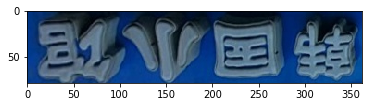

In [ ]:
# 参考代码：
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/tools/infer/predict_cls.py
!cd inference && wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar -O ch_ppocr_mobile_v2.0_cls_infer.tar && tar -xf ch_ppocr_mobile_v2.0_cls_infer.tar

# 方向分类器分类
!python tools/infer/predict_cls.py --image_dir="./doc/imgs_words/ch/word_1.jpg" --cls_model_dir="./inference/ch_ppocr_mobile_v2.0_cls_infer" --use_gpu=False

# 读入图像
import cv2
img = cv2.imread("./doc/imgs_words/ch/word_1.jpg")

plt.imshow(img[:,:,::-1])
plt.show()

# 旋转180度
img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
cv2.imwrite("./test.png", img)

# 对旋转后图像使用方向分类器进行分类
!python tools/infer/predict_cls.py --image_dir="./test.png" --cls_model_dir="./inference/ch_ppocr_mobile_v2.0_cls_infer" --use_gpu=False

plt.imshow(img[:,:,::-1])
plt.show()


### 2.2.3 输入分辨率优化

一般来说，当图像的输入分辨率提高时，精度也会提高。由于方向分类器的骨干网络参数量很小，即使提高了分辨率也不会导致推理时间的明显增加。我们将方向分类器的输入图像尺度从`3x32x100`增加到`3x48x192`，方向分类器的精度从`92.1%`提升至`94.0%`，但是预测耗时仅仅从`3.19ms`提升至`3.21ms`。

下面给出两种尺度下的图像大小对比。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/7f7fbe95eb3a4d14ac6def76874ce27559436040b91840688337f9a9f72c1a8d"  width = "1200" />
</div>
<center>32x100和48x192尺度下的图像大小对比</center>


### 2.2.4 模型量化策略-PACT

模型量化是一种将浮点计算转成低比特定点计算的技术，可以使神经网络模型具有更低的延迟、更小的体积以及更低的计算功耗。

模型量化主要分为离线量化和在线量化。其中，离线量化是指一种利用KL散度等方法来确定量化参数的定点量化方法，量化后不需要再次训练；在线量化是指在训练过程中确定量化参数，相比离线量化模式，它的精度损失更小。

PACT(PArameterized Clipping acTivation)是一种新的在线量化方法，可以**提前从激活层中去除一些极端值**。在去除极端值后，模型可以学习更合适的量化参数。普通PACT方法的激活值的预处理是基于RELU函数的，公式如下：

$$

y=P A C T(x)=0.5(|x|-|x-\alpha|+\alpha)=\left\{\begin{array}{cc}
0 & x \in(-\infty, 0) \\
x & x \in[0, \alpha) \\
\alpha & x \in[\alpha,+\infty)
\end{array}\right.

$$

所有大于特定阈值的激活值都会被重置为一个常数。然而，MobileNetV3中的激活函数不仅是ReLU，还包括hardswish。因此使用普通的PACT量化会导致更高的精度损失。因此，为了减少量化损失，我们将激活函数的公式修改为：

$$

y=P A C T(x)=\left\{\begin{array}{rl}
-\alpha & x \in(-\infty,-\alpha) \\
x & x \in[-\alpha, \alpha) \\
\alpha & x \in[\alpha,+\infty)
\end{array}\right.

$$

PaddleOCR中提供了适用于PP-OCR套件的量化脚本。具体链接可以参考[PaddleOCR模型量化教程](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/deploy/slim/quantization/README.md)。


### 2.2.5 方向分类器配置说明

训练方向分类器时，配置文件中的部分关键字段和说明如下所示。完整配置文件可以参考[cls_mv3.yml](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/configs/cls/cls_mv3.yml)。

```yaml
Architecture:
  model_type: cls
  algorithm: CLS
  Transform:
  Backbone:
    name: MobileNetV3                                                 # 配置分类模型为MobileNetV3
    scale: 0.35
    model_name: small
  Neck:
  Head:
    name: ClsHead
    class_dim: 2

Train:
  dataset:
    name: SimpleDataSet
    data_dir: ./train_data/cls
    label_file_list:
      - ./train_data/cls/train.txt
    transforms:
      - DecodeImage: # load image
          img_mode: BGR
          channel_first: False
      - ClsLabelEncode: # Class handling label
      - RecAug:                                                    
          use_tia: False                                             # 配置BDA数据增强，不使用TIA数据增强
      - RandAugment:                                                 # 配置随机增强数据增强方法
      - ClsResizeImg:
          image_shape: [3, 48, 192]                                  # 这里将[3, 32, 100]修改为[3, 48, 192]，进行输入分辨率优化
      - KeepKeys:
          keep_keys: ['image', 'label'] # dataloader will return list in this order
  loader:
    shuffle: True
    batch_size_per_card: 512
    drop_last: True
    num_workers: 8
```

### 2.2.5 方向分类器实验总结

在方向分类器模型优化中，我们使用轻量化骨干网络以及模型量化，最终将模型从**0.85M**降低到了**0.46M**，使用组合数据增广、高分辨率等特征，最终将模型精度提升了超过**2%**。消融实验对比如下所示。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/65b6e5d75f22403aba50665a1ab6dbba51cdb47eff0845d1909e5e54fd48e336"  width = "1200" />
</div>
<center>方向分类器消融实验</center>


## 2.3 文本识别

PP-OCR中，文本识别器使用的是CRNN模型。训练的时候使用CTC loss去解决不定长文本的预测问题。

CRNN模型结构如下所示。

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/6c4f0d8e87de400691764107c7b1bd374c695a94d7de479da1c1de36a1cca238"  width = "800" />
</div>
<center>CRNN结构图</center>

PP-OCR针对文本识别器，从骨干网络、头部结构优化、数据增强、正则化策略、特征图下采样策略、量化等多个角度进行模型优化，具体消融实验如下所示。

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/44bcc2e797114171aaf584e4d7c79e19cf4ac1fc3e254ad7bdb5cbc01463c790"  width = "800" />
</div>
<center>CRNN识别模型消融实验</center>

下面详细介绍文本识别模型的具体优化策略。


### 2.3.1 轻量级骨干网络和头部结构

* 轻量级骨干网络

在文本识别中，仍然采用了与文本检测相同的MobileNetV3作为backbone。选自MobileNetV3_small_x0.5进一步地平衡精度和效率。如果不要求模型大小的话，可以选择MobileNetV3_small_x1，模型大小仅增加5M，精度明显提高。

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/6272a6cfdc7a431db44407c0e60c17abc259f8c83dc7422eb60ecb87f322a2e1"  width = "800" />
</div>
<center>不同骨干网络下的识别模型精度对比</center>

* 轻量级头部结构

CRNN中，用于解码的轻量级头(head)是一个全连接层，用于将序列特征解码为普通的预测字符。序列特征的维数对文本识别器的模型大小影响非常大，特别是对于6000多个字符的中文识别场景（序列特征维度若设置为256，则仅仅是head部分的模型大小就为**6.7M**）。在PP-OCR中，我们针对序列特征的维度展开实验，最终将其设置为48，平衡了精度与效率。部分消融实验结论如下。

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/e9f020c2748d4870b273a2c3ada03212d2791520baf949ac84b78429251bff2a"  width = "600" />
</div>
<center>不同序列特征维度的精度对比</center>


### 2.3.2 数据增强

除了前面提到的经常用于文本识别的BDA（基本数据增强），TIA（Luo等人，2020）也是一种有效的文本识别数据增强方法。TIA是一种针对场景文字的数据增强方法，它在图像中设置了多个基准点，然后随机移动点，通过几何变换生成新图像，这样大大提升了数据的多样性以及模型的泛化能力。TIA的基本流程图如图所示：

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/f7883b2263e64eaf853b9bf02fc2be5fb737aefd97e74a4db158943eae792a23"  width = "600" />
</div>

实验证明，使用TIA数据增广，可以帮助文本识别模型的精度在一个极高的baseline上面进一步提升**0.9%**。

下面是TIA中三种涉及到的数据增广的可视化效果图。

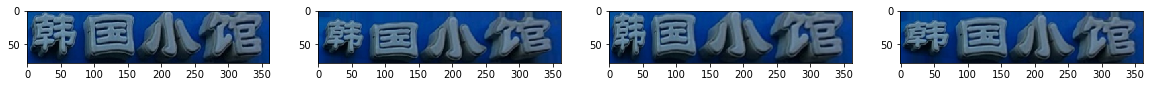

In [ ]:
# 参考代码：
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/data/imaug/text_image_aug/augment.py
import cv2
from ppocr.data.imaug.rec_img_aug import tia_distort, tia_stretch, tia_perspective
img = cv2.imread("./doc/imgs_words/ch/word_1.jpg")

img_out1 = tia_distort(img, 2.5)
img_out2 = tia_stretch(img, 3)
img_out3 = tia_perspective(img)
plt.figure(figsize=(20, 8))
plt.subplot(1,4,1)
plt.imshow(img[:,:,::-1])
plt.subplot(1,4,2)
plt.imshow(img_out1[:,:,::-1])
plt.subplot(1,4,3)
plt.imshow(img_out2[:,:,::-1])
plt.subplot(1,4,4)
plt.imshow(img_out3[:,:,::-1])
plt.show()

### 2.3.3 学习率策略和正则化

在识别模型训练中，学习率下降策略与文本检测相同，也使用了Cosine+Warmup的学习率策略。

正则化是一种广泛使用的避免过度拟合的方法，一般包含L1正则化和L2正则化。在大多数使用场景中，我们都使用L2正则化。它主要的原理就是计算网络中权重的L2范数，添加到损失函数中。在L2正则化的帮助下，网络的权重趋向于选择一个较小的值，最终整个网络中的参数趋向于0，从而缓解模型的过拟合问题，提高了模型的泛化性能。

我们实验发现，对于文本识别，L2正则化对识别准确率有很大的影响。

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/44bcc2e797114171aaf584e4d7c79e19cf4ac1fc3e254ad7bdb5cbc01463c790"  width = "800" />
</div>
<center>CRNN识别模型消融实验</center>

### 2.3.4 特征图降采样策略

我们在做检测、分割、OCR等下游视觉任务时，骨干网络一般都是使用的图像分类任务中的骨干网络，它的输入分辨率一般设置为224x224，降采样时，一般宽度和高度会同时降采样。

但是对于文本识别任务来说，由于输入图像一般是32x100，长宽比非常不平衡，此时对宽度和高度同时降采样，会导致特征损失严重，因此图像分类任务中的骨干网络应用到文本识别任务中需要进行特征图降采样方面的适配（**如果大家自己换骨干网络的话，这里也需要注意一下**）。

在PaddleOCR中，CRNN中文文本识别模型设置的输入图像的高度和宽度设置为32和320。原始MobileNetV3来自分类模型，如前文所述，需要调整降采样的步长，适配文本图像输入分辨率。具体地，为了保留更多的水平信息，我们将下采样特征图的步长从 **（2,2）** 修改为 **（2,1）** ，第一次下采样除外。最终如下图所示。

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/330608b3e6114eb49172b83864bd1caf160a46be759349f3a89ee08e583e9f46"  width = "800" />
</div>
<center>降采样步长策略优化可视化</center>

为了保留更多的垂直信息，我们进一步将第二次下采样特征图的步长从 **（2,1）** 修改为 **（1,1）**。因此，第二个下采样特征图的步长s2会显著影响整个特征图的分辨率和文本识别器的准确性。在PP-OCR中，s2被设置为（1,1），可以获得更好的性能。同时，由于水平的分辨率增加，CPU的推理时间从`11.84ms` 增加到 `12.96ms`。

下面给出了stride优化前后的特征图尺度对比。虽然最终输出特征图尺度相同，但是stride从(2,1)修改为(1,1)之后，特征信息在编码的过程中被保留得更为完整。

In [ ]:
# 参考代码：
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/modeling/backbones/rec_mobilenet_v3.py
from ppocr.modeling.backbones.rec_mobilenet_v3 import MobileNetV3

mv3_ori = MobileNetV3(model_name="small", scale=0.5, small_stride=[2,2,2,2])
mv3_new = MobileNetV3(model_name="small", scale=0.5, small_stride=[1,2,2,2])

x = paddle.rand([1, 3, 32, 320])

y_ori = mv3_ori(x)
y_new = mv3_new(x)

print(y_ori.shape)
print(y_new.shape)

[1, 288, 1, 80]
[1, 288, 1, 80]



### 2.3.5 PACT 在线量化策略

我们采用与方向分类器量化类似的方案来减小文本识别器的模型大小。由于LSTM量化的复杂性，PP-OCR中没有对LSTM进行量化。使用该量化策略之后，模型大小减小`67.4%`、预测速度加速`8%`、准确率提升`1.6%`，量化可以减少模型冗余，增强模型的表达能力。

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/0840afd4a40c4cc39352287c18d6de57d47fe43587804c1baadb924894881397"  width = "600" />
</div>
<center>模型量化消融实验</center>

### 2.3.6 文字识别预训练模型

使用合适的预训练模型可以加快模型的收敛速度。在真实场景中，用于文本识别的数据通常是有限的。PP-OCR中，我们合成了千万级别的数据，对模型进行训练，之后再基于该模型，在真实数据上微调，最终识别准确率从从`65.81%`提升到`69%`。

### 2.3.7 文本识别配置说明

下面给出CRNN的训练配置简要说明，完整的配置文件可以参考：[rec_chinese_lite_train_v2.0.yml](https://github.com/PaddlePaddle/PaddleOCR/blob/release%2F2.4/configs/rec/ch_ppocr_v2.0/rec_chinese_lite_train_v2.0.yml)。


```yaml
Optimizer:
  name: Adam
  beta1: 0.9
  beta2: 0.999
  lr:
    name: Cosine                                 # 配置Cosine 学习率下降策略
    learning_rate: 0.001 
    warmup_epoch: 5                              # 配置预热学习率
  regularizer:    
    name: 'L2'                                   # 配置L2正则
    factor: 0.00001

Architecture:
  model_type: rec
  algorithm: CRNN
  Transform:
  Backbone:
    name: MobileNetV3                             # 配置Backbone
    scale: 0.5
    model_name: small
    small_stride: [1, 2, 2, 2]                     # 配置下采样的stride
  Neck:
    name: SequenceEncoder
    encoder_type: rnn
    hidden_size: 48                               # 配置最后一层全连接层的维度
  Head:
    name: CTCHead
    fc_decay: 0.00001
 
 Train:
  dataset:
    name: SimpleDataSet
    data_dir: ./train_data/
    label_file_list: ["./train_data/train_list.txt"]
    transforms:
      - DecodeImage: # load image
          img_mode: BGR
          channel_first: False
      - RecAug:                                  # 配置数据增强BDA和TIA，TIA默认使用
      - CTCLabelEncode: # Class handling label
      - RecResizeImg:
          image_shape: [3, 32, 320]
      - KeepKeys:
          keep_keys: ['image', 'label', 'length'] # dataloader will return list in this order
  loader:
    shuffle: True
    batch_size_per_card: 256
    drop_last: True
    num_workers: 8
 ```

### 2.3.8 识别优化小结

在模型体积方面，PP-OCR使用轻量级骨干网络、序列维度裁剪、模型量化的策略，将模型大小从4.5M减小至1.6M。在精度方面，使用TIA数据增强、Cosine-warmup学习率策略、L2正则、特征图分辨率改进、预训练模型等优化策略，最终在验证集上提升`15.4%`。

PP-OCR中部分识别效果如下所示。

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/8da2664561ac47d2b3db3a9957fb81a39d5b8b06f85346a48fe4ac9fd6ff70b3"  width = "600" />
</div>

文本识别模型的代码演示如下。

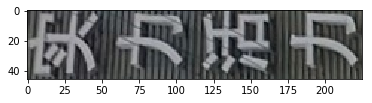

--2021-12-24 21:50:31--  https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_rec_infer.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 182.61.200.195, 182.61.200.229, 2409:8c04:1001:1002:0:ff:b001:368a
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|182.61.200.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8875520 (8.5M) [application/x-tar]
Saving to: ‘ch_PP-OCRv2_rec_infer.tar’

ch_PP-OCRv2_rec_inf 100%[===================>]   8.46M  24.2MB/s    in 0.4s    

2021-12-24 21:50:31 (24.2 MB/s) - ‘ch_PP-OCRv2_rec_infer.tar’ saved [8875520/8875520]

[2021/12/24 21:50:33] root INFO: Predicts of ./doc/imgs_words/ch/word_4.jpg:('实力活力', 0.9409585)


In [ ]:
# 可视化原图
img = cv2.imread("./doc/imgs_words/ch/word_4.jpg")
plt.imshow(img[..., ::-1])
plt.show()

!cd inference && wget https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_rec_infer.tar -O ch_PP-OCRv2_rec_infer.tar && tar -xf ch_PP-OCRv2_rec_infer.tar
!python tools/infer/predict_rec.py --image_dir="./doc/imgs_words/ch/word_4.jpg" --rec_model_dir="./inference/ch_PP-OCRv2_rec_infer" --use_gpu=False

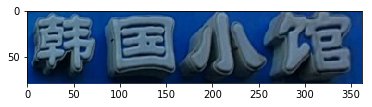

[2021/12/24 21:52:00] root INFO: Predicts of ././doc/imgs_words/ch/word_1.jpg:('韩国小馆', 0.9967349)


In [ ]:
import cv2
# 对 ./doc/imgs_words/ch/word_1.jpg 旋转180度得到
img = cv2.imread("./doc/imgs_words/ch/word_1.jpg")

plt.imshow(img[:,:,::-1])
plt.show()

!python tools/infer/predict_rec.py --image_dir="././doc/imgs_words/ch/word_1.jpg" --rec_model_dir="./inference/ch_PP-OCRv2_rec_infer" --use_gpu=False


# 3. PP-OCRv2优化策略解读


第2节的内容主要是对PP-OCR以及它的19个优化策略进行了详细介绍。

相比于PP-OCR， PP-OCRv2 在骨干网络、数据增广、损失函数这三个方面进行进一步优化，解决端侧预测效率较差、背景复杂以及相似字符的误识等问题，同时引入了知识蒸馏训练策略，进一步提升模型精度。具体地：

* 检测模型优化: (1) 采用 CML 协同互学习知识蒸馏策略；(2) CopyPaste 数据增广策略；
* 识别模型优化: (1) PP-LCNet 轻量级骨干网络；(2) U-DML 改进知识蒸馏策略； (3) Enhanced CTC loss 损失函数改进。

本节主要基于文字检测和识别模型的优化过程，去解读PP-OCRv2的优化策略。

## 3.1 文字检测模型优化详解

文字检测模型优化过程中，采用 CML 协同互学习知识蒸馏以及 CopyPaste 数据增广策略；最终将文字检测模型在大小不变的情况下，Hmean从 **0.759** 提升至 **0.795**，具体消融实验如下所示。

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/71c31fc78946459d9b2b0a5aeae75e9bf784399a73554bc79f8c25716ed9dcbe"  width = "800" />
</div>
<center>PP-OCRv2检测模型消融实验</center>

### 3.1.1 CML知识蒸馏策略

知识蒸馏的方法在部署中非常常用，通过使用大模型指导小模型学习的方式，在通常情况下可以使得小模型在预测耗时不变的情况下，精度得到进一步的提升，从而进一步提升实际部署的体验。

标准的蒸馏方法是通过一个大模型作为 Teacher 模型来指导 Student 模型提升效果，而后来又发展出 DML 互学习蒸馏方法，即通过两个结构相同的模型互相学习，相比于前者，DML 脱离了对大的 Teacher 模型的依赖，蒸馏训练的流程更加简单，模型产出效率也要更高一些。

PP-OCRv2 文字检测模型中使用的是三个模型之间的 CML (Collaborative Mutual Learning) 协同互蒸馏方法，既包含两个相同结构的 Student 模型之间互学习，同时还引入了较大模型结构的 Teacher 模型。CML与其他蒸馏算法的对比如下所示。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/0d2eb64faebe41648631c656eeab8ba3d27e2f5617e9486b8eb26dd12bafbf43"  width = "800" />
</div>
<center>CML与其他知识蒸馏算法的对比</center>

具体地，文本检测任务中，CML的结构框图如下所示。这里的 response maps 指的就是DBNet最后一层的概率图输出 (Probability map) 。在整个训练过程中，总共包含3个损失函数。

* GT loss
* DML loss
* Distill loss

这里的 Teacher 模型的骨干网络为 ResNet18_vd，2 个 Student 模型的骨干网络为 MobileNetV3。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/7886f63f94b84215812e24377e12e6f1655dbc4971054659ade9850355a6125f"  width = "800" />
</div>
<center>CML结构框图</center>

* GT loss

两个 Student 模型中大部分的参数都是从头初始化的，因此它们在训练的过程中需要受到 groundtruth (GT) 信息 的监督。DBNet 训练任务的 pipeline 如下所示。其输出主要包含 3 种 feature map，具体如下所示。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/1506d74093f247589dc7f1adc3666c9de9075b2d2e704a668afda42a3b3c7a71"  width = "600" />
</div>
<center>DBNet头部结构</center>

对这 3 种 feature map 使用不同的 loss function 进行监督，具体如下表所示。

<center>
  
|  Feature map     | Loss function   | weight   |
| :------------:  | :-------------: | :------: |
|  Probability map  | Binary cross-entropy loss   | 1.0   |
|  Binary map  | Dice loss   |   $\alpha$  |
|  Threshold map  | L1 loss   | $\beta$   |

</center>


最终GT loss可以表示为如下所示。

$$ Loss_{gt}(T_{out}, gt) = l_{p}(S_{out}, gt) + \alpha l_{b}(S_{out}, gt) + \beta l_{t}(S_{out}, gt) $$ 


* DML loss

对于 2 个完全相同的 Student 模型来说，因为它们的结构完全相同，因此对于相同的输入，应该具有相同的输出，DBNet 最终输出的是概率图 (response maps)，因此基于 KL 散度，计算 2 个 Student 模型的 DML loss，具体计算方式如下。

$$ Loss_{dml} = \frac{KL(S1_{pout} || S2_{pout}) + KL(S2_{pout} || S1_{pout})}{2} $$

其中 `KL(·|·)`是 KL 散度的计算公式，最终这种形式的 DML loss 具有对称性。


* Distill loss

CML 中，引入了 Teacher 模型，来同时监督 2 个 Student 模型。PP-OCRv2 中只对特征 `Probability map` 进行蒸馏的监督。具体地，对于其中一个 Student 模型，计算方法如下所示， lp(·) 和 lb(·) 分别表示 Binary cross-entropy loss 和 Dice loss。另一个 Student 模型的 loss 计算过程完全相同。

$$ Loss_{distill} = \gamma l_{p}(S_{out}, f_{dila}(T_{out})) + l_{b}(S_{out}, f_{dila}(T_{out})) $$

最终，将上述三个 loss 相加，就得到了用于 CML 训练的损失函数。


检测配置文件为[ch_PP-OCRv2_det_cml.yml](https://github.com/PaddlePaddle/PaddleOCR/blob/release%2F2.4/configs/det/ch_PP-OCRv2/ch_PP-OCRv2_det_cml.yml)，蒸馏结构部分的配置和部分解释如下。


```yaml
Architecture:
  name: DistillationModel     # 模型名称，这是通用的蒸馏模型表示。
  algorithm: Distillation     # 算法名称，
  Models:                     # 模型，包含子网络的配置信息
    Teacher:                  # Teacher子网络，包含`pretrained`与`freeze_params`信息以及其他用于构建子网络的参数
      freeze_params: true     # 是否固定Teacher网络的参数
      pretrained: ./pretrain_models/ch_ppocr_server_v2.0_det_train/best_accuracy # 预训练模型
      return_all_feats: false # 是否返回所有的特征，为True时，会将backbone、neck、head等模块的输出都返回
      model_type: det         # 模型类别
      algorithm: DB           # Teacher网络的算法名称
      Transform:
      Backbone:
        name: ResNet
        layers: 18
      Neck:
        name: DBFPN
        out_channels: 256
      Head:
        name: DBHead
        k: 50
    Student:                   # Student子网络
      freeze_params: false
      pretrained: ./pretrain_models/MobileNetV3_large_x0_5_pretrained
      return_all_feats: false
      model_type: det
      algorithm: DB
      Backbone:
        name: MobileNetV3
        scale: 0.5
        model_name: large
        disable_se: True
      Neck:
        name: DBFPN
        out_channels: 96
      Head:
        name: DBHead
        k: 50
    Student2:                  # Student2子网络
      freeze_params: false
      pretrained: ./pretrain_models/MobileNetV3_large_x0_5_pretrained
      return_all_feats: false
      model_type: det
      algorithm: DB
      Transform:
      Backbone:
        name: MobileNetV3
        scale: 0.5
        model_name: large
        disable_se: True
      Neck:
        name: DBFPN
        out_channels: 96
      Head:
        name: DBHead
        k: 50
```

`DistillationModel`类的实现在[distillation_model.py](https://github.com/PaddlePaddle/PaddleOCR/blob/release%2F2.4/ppocr/modeling/architectures/distillation_model.py)文件中，`DistillationModel`类的实现与部分讲解如下。

```python
class DistillationModel(nn.Layer):
    def __init__(self, config):
        """
        the module for OCR distillation.
        args:
            config (dict): the super parameters for module.
        """
        super().__init__()
        self.model_list = []
        self.model_name_list = []
        # 根据Models中的每个字段，抽取出子网络的名称以及对应的配置
        for key in config["Models"]:
            model_config = config["Models"][key]
            freeze_params = False
            pretrained = None
            if "freeze_params" in model_config:
                freeze_params = model_config.pop("freeze_params")
            if "pretrained" in model_config:
                pretrained = model_config.pop("pretrained")
            # 根据每个子网络的配置，基于BaseModel生成子网络
            model = BaseModel(model_config)
            # 判断是否加载预训练模型
            if pretrained is not None:
                load_pretrained_params(model, pretrained)
            # 判断是否需要固定该子网络的模型参数
            if freeze_params:
                for param in model.parameters():
                    param.trainable = False
            self.model_list.append(self.add_sublayer(key, model))
            self.model_name_list.append(key)

    def forward(self, x):
        result_dict = dict()
        for idx, model_name in enumerate(self.model_name_list):
            result_dict[model_name] = self.model_list[idx](x)
        return result_dict
```

使用下面的命令，可以快速完成蒸馏模型的初始化过程。

In [ ]:
# 参考代码
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/modeling/architectures/__init__.py
from tools.program import load_config
from ppocr.modeling.architectures import build_model
config_path = "./configs/det/ch_PP-OCRv2/ch_PP-OCRv2_det_cml.yml"
config = load_config(config_path)
model = build_model(config['Architecture'])
print(model)

DistillationModel(
  (Teacher): BaseModel(
    (backbone): ResNet(
      (conv1_1): ConvBNLayer(
        (_pool2d_avg): AvgPool2D(kernel_size=2, stride=2, padding=0)
        (_conv): Conv2D(3, 32, kernel_size=[3, 3], stride=[2, 2], padding=1, data_format=NCHW)
        (_batch_norm): BatchNorm()
      )
      (conv1_2): ConvBNLayer(
        (_pool2d_avg): AvgPool2D(kernel_size=2, stride=2, padding=0)
        (_conv): Conv2D(32, 32, kernel_size=[3, 3], padding=1, data_format=NCHW)
        (_batch_norm): BatchNorm()
      )
      (conv1_3): ConvBNLayer(
        (_pool2d_avg): AvgPool2D(kernel_size=2, stride=2, padding=0)
        (_conv): Conv2D(32, 64, kernel_size=[3, 3], padding=1, data_format=NCHW)
        (_batch_norm): BatchNorm()
      )
      (pool2d_max): MaxPool2D(kernel_size=3, stride=2, padding=1)
      (bb_0_0): BasicBlock(
        (conv0): ConvBNLayer(
          (_pool2d_avg): AvgPool2D(kernel_size=2, stride=2, padding=0)
          (_conv): Conv2D(64, 64, kernel_size=[3, 3], p

可以通过下面的方式快速体验CML蒸馏的训练过程。

In [ ]:
# 参考代码
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/tools/train.py
os.chdir("/home/aistudio/PaddleOCR/")
!mkdir train_data
!wget https://paddleocr.bj.bcebos.com/dataset/det_data_lesson_demo.tar -O det_data_lesson_demo.tar && tar -xf det_data_lesson_demo.tar && rm det_data_lesson_demo.tar
!mkdir pretrain_models && wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_server_v2.0_det_train.tar && tar -xf ch_ppocr_server_v2.0_det_train.tar
!mv ch_ppocr_server_v2.0_det_train pretrain_models/ && rm ch_ppocr_server_v2.0_det_train.tar
# 训练脚本
# 注意：这里只训练了一个epoch，仅用于快速演示，指标会很差
!python tools/train.py -c configs/det/ch_PP-OCRv2/ch_PP-OCRv2_det_cml.yml \
    -o Global.pretrained_model="" \
    Train.dataset.data_dir="./det_data_lesson_demo/" \
    Train.dataset.label_file_list=["./det_data_lesson_demo/train.txt"] \
    Train.loader.num_workers=0 \
    Eval.dataset.data_dir="./det_data_lesson_demo/" \
    Eval.dataset.label_file_list=["./det_data_lesson_demo/eval.txt"] \
    Eval.loader.num_workers=0 \
    Optimizer.lr.learning_rate=0.00025 \
    Global.epoch_num=1

mkdir: cannot create directory ‘train_data’: File exists
--2021-12-24 22:09:31--  https://paddleocr.bj.bcebos.com/dataset/det_data_lesson_demo.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 182.61.200.195, 182.61.200.229, 2409:8c04:1001:1002:0:ff:b001:368a
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|182.61.200.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 449465021 (429M) [application/x-tar]
Saving to: ‘det_data_lesson_demo.tar’

det_data_lesson_dem 100%[===================>] 428.64M  53.9MB/s    in 8.5s    

2021-12-24 22:09:39 (50.7 MB/s) - ‘det_data_lesson_demo.tar’ saved [449465021/449465021]

mkdir: cannot create directory ‘pretrain_models’: File exists
[2021/12/24 22:09:46] root INFO: Architecture : 
[2021/12/24 22:09:46] root INFO:     Models : 
[2021/12/24 22:09:46] root INFO:         Student : 
[2021/12/24 22:09:46] root INFO:             Backbone : 
[2021/12/24 22:09:46] root INFO:                 disable


### 3.1.2 数据增广

数据增广是提升模型泛化能力重要的手段之一，CopyPaste 是一种新颖的数据增强技巧，已经在目标检测和实例分割任务中验证了有效性。利用 CopyPaste，可以合成文本实例来平衡训练图像中的正负样本之间的比例。相比而言，传统图像旋转、随机翻转和随机裁剪是无法做到的。

CopyPaste 主要步骤包括：

1. 随机选择两幅训练图像；
2. 随机尺度抖动缩放；
3. 随机水平翻转；
4. 随机选择一幅图像中的目标子集；
5. 粘贴在另一幅图像中随机的位置。


这样就比较好地提升了样本丰富度，同时也增加了模型对环境的鲁棒性。如下图所示，通过在左下角的图中裁剪出来的文本，随机旋转缩放之后粘贴到左上角的图像中，进一步丰富了该文本在不同背景下的多样性。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/b44c9cd5241d444c8c76010f105a3e1abf2209414922457385d8e0eb2800be2a"  width = "1200" />
</div>

如果希望在模型训练中使用`CopyPaste`，只需在`Train.transforms`配置字段中添加`CopyPaste`即可，如下所示。

```yaml
Train:
  dataset:
    name: SimpleDataSet
    data_dir: ./train_data/icdar2015/text_localization/
    label_file_list:
      - ./train_data/icdar2015/text_localization/train_icdar2015_label.txt
    ratio_list: [1.0]
    transforms:
      - DecodeImage: # load image
          img_mode: BGR
          channel_first: False
      - DetLabelEncode: # Class handling label
      - CopyPaste:  # 添加CopyPaste
      - IaaAugment:
          augmenter_args:
            - { 'type': Fliplr, 'args': { 'p': 0.5 } }
            - { 'type': Affine, 'args': { 'rotate': [-10, 10] } }
            - { 'type': Resize, 'args': { 'size': [0.5, 3] } }
      - EastRandomCropData:
          size: [960, 960]
          max_tries: 50
          keep_ratio: true
      - MakeBorderMap:
          shrink_ratio: 0.4
          thresh_min: 0.3
          thresh_max: 0.7
      - MakeShrinkMap:
          shrink_ratio: 0.4
          min_text_size: 8
      - NormalizeImage:
          scale: 1./255.
          mean: [0.485, 0.456, 0.406]
          std: [0.229, 0.224, 0.225]
          order: 'hwc'
      - ToCHWImage:
      - KeepKeys:
          keep_keys: ['image', 'threshold_map', 'threshold_mask', 'shrink_map', 'shrink_mask'] # the order of the dataloader list
  loader:
    shuffle: True
    drop_last: False
    batch_size_per_card: 8
    num_workers: 4
```

`CopyPaste`的具体实现可以参考[copy_paste.py](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/data/imaug/copy_paste.py)。

下面基于icdar2015检测数据集，演示CopyPaste的实际运行过程。

In [ ]:
import os
import sys

os.chdir("/home/aistudio/PaddleOCR/")
!unzip -oq /home/aistudio/data/data46088/icdar2015.zip

In [ ]:
# 参考代码：
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/data/simple_dataset.py
import logging
import random
import numpy as np

from ppocr.data.imaug import create_operators, transform

logger = logging.basicConfig()

# CopyPaste示例的类
class CopyPasteDemo(object):
    def __init__(self, ):
        self.data_dir = "./icdar2015/text_localization/"
        self.label_file_list = "./icdar2015/text_localization/train_icdar2015_label.txt"
        self.data_lines = self.get_image_info_list(self.label_file_list)
        self.data_idx_order_list = list(range(len(self.data_lines)))
        transforms = [
            {"DecodeImage": {"img_mode": "BGR", "channel_first": False}},
            {"DetLabelEncode": {}},
            {"CopyPaste": {"objects_paste_ratio": 1.0}},
        ]
        self.ops = create_operators(transforms)
    
    # 选择一张图像，将其中的内容拷贝到当前图像中
    def get_ext_data(self, idx):
        ext_data_num = 1
        ext_data = []

        load_data_ops = self.ops[:2]

        next_idx = idx

        while len(ext_data) < ext_data_num:
            next_idx = (next_idx + 1) % len(self)
            file_idx = self.data_idx_order_list[next_idx]
            data_line = self.data_lines[file_idx]
            data_line = data_line.decode('utf-8')
            substr = data_line.strip("\n").split("\t")
            file_name = substr[0]
            label = substr[1]
            img_path = os.path.join(self.data_dir, file_name)
            data = {'img_path': img_path, 'label': label}
            if not os.path.exists(img_path):
                continue
            with open(data['img_path'], 'rb') as f:
                img = f.read()
                data['image'] = img
            data = transform(data, load_data_ops)
            if data is None:
                continue
            ext_data.append(data)
        return ext_data
    
    # 获取图像信息
    def get_image_info_list(self, file_list):
        if isinstance(file_list, str):
            file_list = [file_list]
        data_lines = []
        for idx, file in enumerate(file_list):
            with open(file, "rb") as f:
                lines = f.readlines()
                data_lines.extend(lines)
        return data_lines

    # 获取DataSet中的一条数据
    def __getitem__(self, idx):
        file_idx = self.data_idx_order_list[idx]
        data_line = self.data_lines[file_idx]
        try:
            data_line = data_line.decode('utf-8')
            substr = data_line.strip("\n").split("\t")
            file_name = substr[0]
            label = substr[1]
            img_path = os.path.join(self.data_dir, file_name)
            data = {'img_path': img_path, 'label': label}
            if not os.path.exists(img_path):
                raise Exception("{} does not exist!".format(img_path))
            with open(data['img_path'], 'rb') as f:
                img = f.read()
                data['image'] = img
            data['ext_data'] = self.get_ext_data(idx)
            outs = transform(data, self.ops)
        except Exception as e:
            print(
                "When parsing line {}, error happened with msg: {}".format(
                    data_line, e))
            outs = None
        if outs is None:
            return
        return outs
    
    def __len__(self):
        return len(self.data_idx_order_list)

copy_paste_demo = CopyPasteDemo()

idx = 1
data1 = copy_paste_demo[idx]
print(data1.keys())
print(data1["img_path"])
print(data1["ext_data"][0]["img_path"])

dict_keys(['img_path', 'label', 'image', 'ext_data', 'polys', 'texts', 'ignore_tags'])
./icdar2015/text_localization/icdar_c4_train_imgs/img_603.jpg
./icdar2015/text_localization/icdar_c4_train_imgs/img_233.jpg


* 下面2张图是在CopyPaste之前的图像。

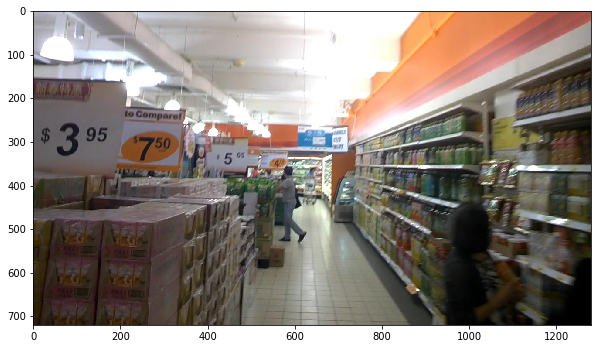

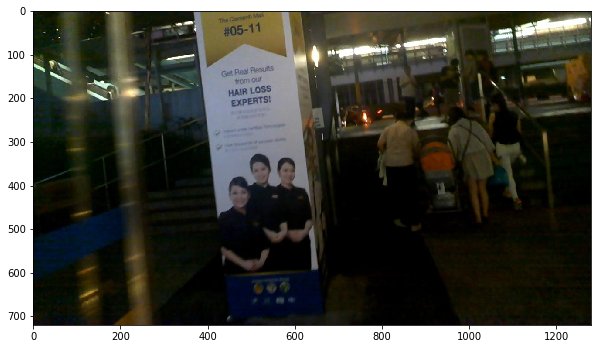

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
img1 = cv2.imread(data1["img_path"])
img2 = cv2.imread(data1["ext_data"][0]["img_path"])
plt.figure(figsize=(10,6))
plt.imshow(img1[:,:,::-1])
plt.show()
plt.figure(figsize=(10,6))
plt.imshow(img2[:,:,::-1])
plt.show()


* 将更新后的标注检测框画出来，如下所示，其中红色框是原始标注信息，蓝色框是经过CopyPaste补充的标注框。

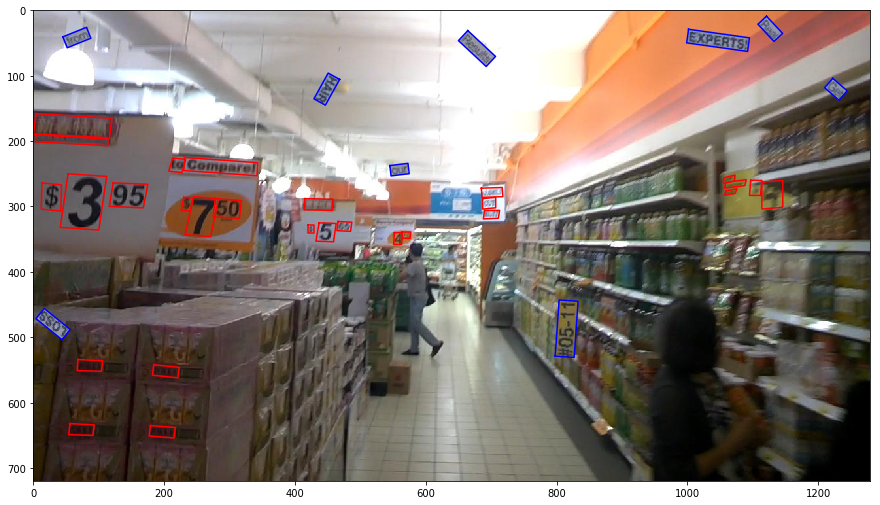

In [ ]:
import json
infos = copy_paste_demo.data_lines[idx]
infos = json.loads(infos.decode('utf-8').split("\t")[1])

img3 = data1["image"].copy()
plt.figure(figsize=(15,10))
plt.imshow(img3[:,:,::-1])
# 原始标注信息
for info in infos:
    xs, ys = zip(*info["points"])
    xs = list(xs)
    ys = list(ys)
    xs.append(xs[0])
    ys.append(ys[0])
    plt.plot(xs, ys, "r")
# 新增的标注信息
for poly_idx in range(len(infos), len(data1["polys"])):
    poly = data1["polys"][poly_idx]
    xs, ys = zip(*poly)
    xs = list(xs)
    ys = list(ys)
    xs.append(xs[0])
    ys.append(ys[0])
    plt.plot(xs, ys, "b")
plt.show()

### 3.1.3 文字检测优化小结


PP-OCRv2中，对文字检测模型采用使用知识蒸馏方案以及数据增广策略，增加模型的泛化性能。最终文字检测模型在大小不变的情况下，Hmean从 **0.759** 提升至 **0.795**，具体消融实验如下所示。

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/71c31fc78946459d9b2b0a5aeae75e9bf784399a73554bc79f8c25716ed9dcbe"  width = "1200" />
</div>
<center>PP-OCRv2检测模型消融实验</center>

PP-OCRv2中检测效果如下所示。

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/5f1a7e4d193e439bb7b10b89460d76c5ee1e2787ea304641834677524c210795"  width = "1000" />
</div>

## 3.2 文本识别模型优化详解

PP-OCRv2文字识别模型优化过程中，采用骨干网络优化、UDML知识蒸馏策略、CTC loss改进等技巧，最终将识别精度从 **66.7%** 提升至 **74.8%**，具体消融实验如下所示。

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/b45a54b41d554858a8714e308c31863354fc544582704583b84205c95cba37c3"  width = "1000" />
</div>
<center>PP-OCRv2识别模型消融实验</center>

### 3.2.1 PP-LCNet轻量级骨干网络

百度提出了一种基于 MKLDNN 加速策略的轻量级 CPU 网络，即 PP-LCNet，大幅提高了轻量级模型在图像分类任务上的性能，对于计算机视觉的下游任务，如文本识别、目标检测、语义分割等，有很好的表现。这里需要注意的是，PP-LCNet是针对**CPU+MKLDNN**这个场景进行定制优化，在分类任务上的速度和精度都远远优于其他模型，因此大家如果有这个使用场景的模型需求的话，也推荐大家去使用。

PP-LCNet 论文地址：[PP-LCNet: A Lightweight CPU Convolutional Neural Network](https://arxiv.org/abs/2109.15099)

PP-LCNet基于MobileNetV1改进得到，其结构图如下所示。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/4d3794e3dd96464b80a3b50a80c7460761bdb1fbea2b4049a744f12d9bef9204"  width = "1000" />
</div>

相比于MobileNetV1，PP-LCNet中融合了MobileNetV3结构中激活函数、头部结构、SE模块等策略优化技巧，同时分析了最后阶段卷积层的卷积核大小，最终该模型在保证速度优势的基础上，精度大幅超越MobileNet、GhostNet等轻量级模型。

具体地，PP-LCNet中共涉及到下面4个优化点。

* 除了 SE 模块，网络中所有的 relu 激活函数替换为 h-swish，精度提升1%-2%
* PP-LCNet 第五阶段，DW 的 kernel size 变为5x5，精度提升0.5%-1%
* PP-LCNet 第五阶段的最后两个 DepthSepConv block 添加 SE 模块， 精度提升0.5%-1%
* GAP 后添加 1280 维的 FC 层，增加特征表达能力，精度提升2%-3%


在ImageNet1k数据集上，PP-LCNet相比于其他目前比较常用的轻量级分类模型，Top1-Acc 与预测耗时如下图所示。可以看出，预测耗时和精度都是要更优的。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/91ac1cc5cf3e439d9bdff598a3fbac5dd059d324c5124dc0a1c1ad4c15b8cd9b"  width = "800" />
</div>

通过下面这种方式，便可以快速完成PP-LCNet识别模型的定义。

In [ ]:
# 参考代码
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/modeling/backbones/rec_mv1_enhance.py
from ppocr.modeling.backbones.rec_mv1_enhance import MobileNetV1Enhance

x = paddle.rand([1, 3, 23, 320])

model = MobileNetV1Enhance(scale=0.5)

y = model(x)
print(y.shape)

[1, 512, 1, 80]


### 3.2.2 U-DML 知识蒸馏策略

对于标准的 DML 策略，蒸馏的损失函数仅包括最后输出层监督，然而对于 2 个结构完全相同的模型来说，对于完全相同的输入，它们的中间特征输出期望也完全相同，因此在最后输出层监督的监督上，可以进一步添加中间输出的特征图的监督信号，作为损失函数，即   PP-OCRv2 中的 U-DML (Unified-Deep Mutual Learning) 知识蒸馏方法。

U-DML 知识蒸馏的算法流程图如下所示。 Teacher 模型与 Student 模型的网络结构完全相同，初始化参数不同，此外，在新增在标准的 DML 知识蒸馏的基础上，新增引入了对于 Feature Map 的监督机制，新增 Feature Loss。

<div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/15c3365ce87a49e4a26f91c93ab828470bceea1941aa47cf80fa7173cbcfcbd8"  width = "1000" />
</div>

在训练的过程中，总共包含 3 种 loss： GT loss，DML loss，Feature loss。

* GT loss

文本识别任务使用的模型结构是 CRNN，因此使用 CTC loss 作为 GT loss， GT loss 计算方法如下所示。

$$ Loss_{ctc} = CTC(S_{hout}, gt) + CTC(T_{hout}, gt) $$

* DML loss 

DML loss 计算方法如下，这里 Teacher 模型与 Student 模型互相计算 KL 散度，最终 DML loss具有对称性。

$$ Loss_{dml} = \frac{KL(S_{pout} || T_{pout}) + KL(T_{pout} || S_{pout})}{2} $$

* Feature loss

Feature loss 使用的是 L2 loss，具体计算方法如下所示。

$$ Loss_{feat} = L2(S_{bout}, T_{bout}) $$

最终，训练过程中的 loss function 计算方法如下所示。

$$ Loss_{total} = Loss_{ctc} + Loss_{dml} + Loss_{feat} $$


此外，在训练过程中通过增加迭代次数，在 Head 部分添加 FC 层等 trick，平衡模型的特征编码与解码的能力，进一步提升了模型效果。


配置文件在[ch_PP-OCRv2_rec_distillation.yml](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/configs/rec/ch_PP-OCRv2/ch_PP-OCRv2_rec_distillation.yml)。

```yaml
Architecture:
  model_type: &model_type "rec"    # 模型类别，rec、det等，每个子网络的的模型类别都与
  name: DistillationModel          # 结构名称，蒸馏任务中，为DistillationModel，用于构建对应的结构
  algorithm: Distillation          # 算法名称
  Models:                          # 模型，包含子网络的配置信息
    Teacher:                       # 子网络名称，至少需要包含`pretrained`与`freeze_params`信息，其他的参数为子网络的构造参数
      pretrained:                  # 该子网络是否需要加载预训练模型
      freeze_params: false         # 是否需要固定参数
      return_all_feats: true       # 子网络的参数，表示是否需要返回所有的features，如果为False，则只返回最后的输出
      model_type: *model_type      # 模型类别
      algorithm: CRNN              # 子网络的算法名称，该子网络剩余参与均为构造参数，与普通的模型训练配置一致
      Transform:
      Backbone:
        name: MobileNetV1Enhance
        scale: 0.5
      Neck:
        name: SequenceEncoder
        encoder_type: rnn
        hidden_size: 64
      Head:
        name: CTCHead
        mid_channels: 96           # Head解码过程中穿插一层
        fc_decay: 0.00002
    Student:                       # 另外一个子网络，这里给的是DML的蒸馏示例，两个子网络结构相同，均需要学习参数
      pretrained:                  # 下面的组网参数同上
      freeze_params: false
      return_all_feats: true
      model_type: *model_type
      algorithm: CRNN
      Transform:
      Backbone:
        name: MobileNetV1Enhance
        scale: 0.5
      Neck:
        name: SequenceEncoder
        encoder_type: rnn
        hidden_size: 64
      Head:
        name: CTCHead
        mid_channels: 96
        fc_decay: 0.00002
```

当然，这里如果希望添加更多的子网络进行训练，也可以按照`Student`与`Teacher`的添加方式，在配置文件中添加相应的字段。比如说如果希望有3个模型互相监督，共同训练，那么`Architecture`可以写为如下格式。

```yaml
Architecture:
  model_type: &model_type "rec"
  name: DistillationModel
  algorithm: Distillation
  Models:
    Teacher:
      pretrained:
      freeze_params: false
      return_all_feats: true
      model_type: *model_type
      algorithm: CRNN
      Transform:
      Backbone:
        name: MobileNetV1Enhance
        scale: 0.5
      Neck:
        name: SequenceEncoder
        encoder_type: rnn
        hidden_size: 64
      Head:
        name: CTCHead
        mid_channels: 96
        fc_decay: 0.00002
    Student:
      pretrained:
      freeze_params: false
      return_all_feats: true
      model_type: *model_type
      algorithm: CRNN
      Transform:
      Backbone:
        name: MobileNetV1Enhance
        scale: 0.5
      Neck:
        name: SequenceEncoder
        encoder_type: rnn
        hidden_size: 64
      Head:
        name: CTCHead
        mid_channels: 96
        fc_decay: 0.00002
    Student2:                       # 知识蒸馏任务中引入的新的子网络，其他部分与上述配置相同
      pretrained:
      freeze_params: false
      return_all_feats: true
      model_type: *model_type
      algorithm: CRNN
      Transform:
      Backbone:
        name: MobileNetV1Enhance
        scale: 0.5
      Neck:
        name: SequenceEncoder
        encoder_type: rnn
        hidden_size: 64
      Head:
        name: CTCHead
        mid_channels: 96
        fc_decay: 0.00002
```

最终该模型训练时，包含3个子网络：`Teacher`, `Student`, `Student2`。

蒸馏模型`DistillationModel`类的具体实现代码可以参考[distillation_model.py](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.3/ppocr/modeling/architectures/distillation_model.py)。

最终模型`forward`输出为一个字典，key为所有的子网络名称，例如这里为`Student`与`Teacher`，value为对应子网络的输出，可以为`Tensor`（只返回该网络的最后一层）和`dict`（也返回了中间的特征信息）。

在识别任务中，为了添加更多损失函数，保证蒸馏方法的可扩展性，将每个子网络的输出保存为`dict`，其中包含子模块输出。以该识别模型为例，每个子网络的输出结果均为`dict`，key包含`backbone_out`,`neck_out`, `head_out`，`value`为对应模块的tensor，最终对于上述配置文件，`DistillationModel`的输出格式如下。

```json
{
  "Teacher": {
    "backbone_out": tensor,
    "neck_out": tensor,
    "head_out": tensor,
  },
  "Student": {
    "backbone_out": tensor,
    "neck_out": tensor,
    "head_out": tensor,
  }
}
```

知识蒸馏任务中，损失函数配置如下所示。

```yaml
Loss:
  name: CombinedLoss                           # 损失函数名称，基于改名称，构建用于损失函数的类
  loss_config_list:                            # 损失函数配置文件列表，为CombinedLoss的必备函数
  - DistillationCTCLoss:                       # 基于蒸馏的CTC损失函数，继承自标准的CTC loss
      weight: 1.0                              # 损失函数的权重，loss_config_list中，每个损失函数的配置都必须包含该字段
      model_name_list: ["Student", "Teacher"]  # 对于蒸馏模型的预测结果，提取这两个子网络的输出，与gt计算CTC loss
      key: head_out                            # 取子网络输出dict中，该key对应的tensor
  - DistillationDMLLoss:                       # 蒸馏的DML损失函数，继承自标准的DMLLoss
      weight: 1.0                              # 权重
      act: "softmax"                           # 激活函数，对输入使用激活函数处理，可以为softmax, sigmoid或者为None，默认为None
      model_name_pairs:                        # 用于计算DML loss的子网络名称对，如果希望计算其他子网络的DML loss，可以在列表下面继续填充
      - ["Student", "Teacher"]
      key: head_out                            # 取子网络输出dict中，该key对应的tensor
  - DistillationDistanceLoss:                  # 蒸馏的距离损失函数
      weight: 1.0                              # 权重
      mode: "l2"                               # 距离计算方法，目前支持l1, l2, smooth_l1
      model_name_pairs:                        # 用于计算distance loss的子网络名称对
      - ["Student", "Teacher"]
      key: backbone_out                        # 取子网络输出dict中，该key对应的tensor
```

上述损失函数中，所有的蒸馏损失函数均继承自标准的损失函数类，主要功能为: 对蒸馏模型的输出进行解析，找到用于计算损失的中间节点(tensor)，再使用标准的损失函数类去计算。

以上述配置为例，最终蒸馏训练的损失函数包含下面3个部分。

- `Student`和`Teacher`的最终输出(`head_out`)与gt的CTC loss，权重为1。在这里因为2个子网络都需要更新参数，因此2者都需要计算与gt的loss。
- `Student`和`Teacher`的最终输出(`head_out`)之间的DML loss，权重为1。
- `Student`和`Teacher`的骨干网络输出(`backbone_out`)之间的l2 loss，权重为1。

`CombinedLoss`类实现如下。

```python
class CombinedLoss(nn.Layer):
    """
    CombinedLoss:
        a combionation of loss function
    """

    def __init__(self, loss_config_list=None):
        super().__init__()
        self.loss_func = []
        self.loss_weight = []
        assert isinstance(loss_config_list, list), (
            'operator config should be a list')
        for config in loss_config_list:
            assert isinstance(config,
                              dict) and len(config) == 1, "yaml format error"
            name = list(config)[0]
            param = config[name]
            assert "weight" in param, "weight must be in param, but param just contains {}".format(
                param.keys())
            self.loss_weight.append(param.pop("weight"))
            self.loss_func.append(eval(name)(**param))

    def forward(self, input, batch, **kargs):
        loss_dict = {}
        loss_all = 0.
        for idx, loss_func in enumerate(self.loss_func):
            loss = loss_func(input, batch, **kargs)
            if isinstance(loss, paddle.Tensor):
                loss = {"loss_{}_{}".format(str(loss), idx): loss}

            weight = self.loss_weight[idx]

            loss = {key: loss[key] * weight for key in loss}

            if "loss" in loss:
                loss_all += loss["loss"]
            else:
                loss_all += paddle.add_n(list(loss.values()))
            loss_dict.update(loss)
        loss_dict["loss"] = loss_all
        return loss_dict
```

关于`CombinedLoss`更加具体的实现可以参考: [combined_loss.py](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/losses/combined_loss.py)。关于`DistillationCTCLoss`等蒸馏损失函数更加具体的实现可以参考[distillation_loss.py](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppocr/losses/distillation_loss.py)。



对于上面3个模型的蒸馏，Loss字段也需要相应修改，同时考虑3个子网络之间的损失，如下所示。

```yaml
Loss:
  name: CombinedLoss                           # 损失函数名称，基于改名称，构建用于损失函数的类
  loss_config_list:                            # 损失函数配置文件列表，为CombinedLoss的必备函数
  - DistillationCTCLoss:                       # 基于蒸馏的CTC损失函数，继承自标准的CTC loss
      weight: 1.0                              # 损失函数的权重，loss_config_list中，每个损失函数的配置都必须包含该字段
      model_name_list: ["Student", "Student2", "Teacher"]  # 对于蒸馏模型的预测结果，提取这三个子网络的输出，与gt计算CTC loss
      key: head_out                            # 取子网络输出dict中，该key对应的tensor
  - DistillationDMLLoss:                       # 蒸馏的DML损失函数，继承自标准的DMLLoss
      weight: 1.0                              # 权重
      act: "softmax"                           # 激活函数，对输入使用激活函数处理，可以为softmax, sigmoid或者为None，默认为None
      model_name_pairs:                        # 用于计算DML loss的子网络名称对，如果希望计算其他子网络的DML loss，可以在列表下面继续填充
      - ["Student", "Teacher"]
      - ["Student2", "Teacher"]
      - ["Student", "Student2"]
      key: head_out                            # 取子网络输出dict中，该key对应的tensor
  - DistillationDistanceLoss:                  # 蒸馏的距离损失函数
      weight: 1.0                              # 权重
      mode: "l2"                               # 距离计算方法，目前支持l1, l2, smooth_l1
      model_name_pairs:                        # 用于计算distance loss的子网络名称对
      - ["Student", "Teacher"]
      - ["Student2", "Teacher"]
      - ["Student", "Student2"]
      key: backbone_out                        # 取子网络输出dict中，该key对应的tensor
```


In [33]:
# 下载数据
!wget -nc https://paddleocr.bj.bcebos.com/dataset/rec_data_lesson_demo.tar && tar -xf rec_data_lesson_demo.tar && rm rec_data_lesson_demo.tar
# # 下载预训练模型
!wget -nc https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_rec_train.tar && tar -xf ch_PP-OCRv2_rec_train.tar && rm ch_PP-OCRv2_rec_train.tar

!python tools/train.py -c configs/rec/ch_PP-OCRv2/ch_PP-OCRv2_rec_distillation.yml \
    -o Train.dataset.data_dir="./rec_data_lesson_demo/" \
    Train.dataset.label_file_list=["./rec_data_lesson_demo/train.txt"] \
    Train.loader.num_workers=0 \
    Train.loader.batch_size_per_card=64 \
    Eval.dataset.data_dir="./rec_data_lesson_demo/" \
    Eval.dataset.label_file_list=["./rec_data_lesson_demo/val.txt"] \
    Eval.loader.num_workers=0 \
    Optimizer.lr.values=[0.0001,0.00001] \
    Global.epoch_num=1 \
    Global.pretrained_model="./ch_PP-OCRv2_rec_train/best_accuracy"

--2021-12-24 22:30:18--  https://paddleocr.bj.bcebos.com/dataset/rec_data_lesson_demo.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 182.61.200.195, 182.61.200.229, 2409:8c04:1001:1002:0:ff:b001:368a
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|182.61.200.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 699098618 (667M) [application/x-tar]
Saving to: ‘rec_data_lesson_demo.tar’

rec_data_lesson_dem 100%[===================>] 666.71M  42.5MB/s    in 16s     

2021-12-24 22:30:34 (40.7 MB/s) - ‘rec_data_lesson_demo.tar’ saved [699098618/699098618]

--2021-12-24 22:30:41--  https://paddleocr.bj.bcebos.com/PP-OCRv2/chinese/ch_PP-OCRv2_rec_train.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 182.61.200.229, 182.61.200.195, 2409:8c04:1001:1002:0:ff:b001:368a
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|182.61.200.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

### 3.2.3 Enhanced CTC loss 改进

中文 OCR 任务经常遇到的识别难点是相似字符数太多，容易误识。借鉴 Metric Learning 中的想法，引入 Center loss，进一步增大类间距离，核心公式如下所示。

$$ L = L_{ctc} + \lambda * L_{center} $$
$$ L_{center} =\sum_{t=1}^T||x_{t} - c_{y_{t}}||_{2}^{2} $$

这里 $x_t$ 表示时间步长 $t$ 处的标签，$c_{y_{t}}$ 表示标签 $y_t$ 对应的 center。

Enhance CTC 中，center 的初始化对结果也有较大影响，在 PP-OCRv2 中，center 初始化的具体步骤如下所示。

1. 基于标准的 CTC loss，训练一个网络；
2. 提取出训练集合中识别正确的图像集合，记为 G ；
3. 将 G 中的图片依次输入网络， 提取head输出时序特征的 $x_t$ 和 $y_t$ 的对应关系，其中 $y_t$ 计算方式如下：

$$ y_{t} = argmax(W * x_{t}) $$

4. 将相同 $y_t$ 对应的 $x_t$ 聚合在一起，取其平均值，作为初始 center。


首先需要基于[configs/rec/ch_PP-OCRv2/ch_PP-OCRv2_rec.yml](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/configs/rec/ch_PP-OCRv2/ch_PP-OCRv2_rec.yml)训练一个基础网络

更多关于Center loss的训练步骤可以参考：[Enhanced CTC Loss使用文档](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/doc/doc_ch/enhanced_ctc_loss.md)

最后，使用[configs/rec/ch_PP-OCRv2/ch_PP-OCRv2_rec_enhanced_ctc_loss.yml](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/configs/rec/ch_PP-OCRv2/ch_PP-OCRv2_rec_enhanced_ctc_loss.yml)进行训练，命令如下所示。

```shell
python tools/train.py -c configs/rec/ch_PP-OCRv2/ch_PP-OCRv2_rec_enhanced_ctc_loss.yml
```

主要改进点为`Loss`字段，相比于标准的`CTCLoss`，添加了`CenterLoss`。配置类别数、特征维度、center路径即可。

```yaml
Loss:
  name: CombinedLoss
  loss_config_list:
  - CTCLoss:
      use_focal_loss: false
      weight: 1.0
  - CenterLoss:
      weight: 0.05
      num_classes: 6625
      feat_dim: 96
      center_file_path: "./train_center.pkl"
```

### 3.2.4 文本识别优化小结

PP-OCRv2文字识别模型优化过程中，对模型从骨干网络、损失函数等角度进行改进，并引入知识蒸馏的训练方法，最终将识别精度从 **66.7%** 提升至 **74.8%**，具体消融实验如下所示。

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/b45a54b41d554858a8714e308c31863354fc544582704583b84205c95cba37c3"  width = "800" />
</div>
<center>PP-OCRv2识别模型消融实验</center>

在PP-OCRv2文字检测的基础上，识别模型的实验效果如下所示。

</div><div align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/12bec5f8e2e94fedbf4f2851f182e6bc7a1cff80a31b4390bedfcfbb7d8d6a6d"  width = "800" />
</div>

# 4. 总结

本章主要介绍PP-OCR以及PP-OCRv2的优化策略。

PP-OCR从骨干网络、学习率策略、数据增广、模型裁剪量化等方面，共使用了19个策略，对模型进行优化瘦身，最终打造了面向服务器端的PP-OCR server系统以及面向移动端的PP-OCR mobile系统。

相比于PP-OCR， PP-OCRv2 在骨干网络、数据增广、损失函数这三个方面进行进一步优化，解决端侧预测效率较差、背景复杂以及相似字符的误识等问题，同时引入了知识蒸馏训练策略，进一步提升模型精度，最终打造了精度、速度远超PP-OCR的文字检测与识别系统。

# 5. 作业

具体内容见课程结业必修中的`优化策略客观题`以及`优化策略实战题`部分。